In [2]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract, desc, and_

In [138]:
class HonoluluHI_WeatherDB():
    connect_string = "sqlite:///Resources/hawaii.sqlite"
    def __init__(self, connect_string=connect_string):
        self.connect_string = connect_string
        self.engine = create_engine(connect_string)
        # reflect an existing database into a new model
        self.Base = automap_base()
        # reflect the tables
        self.Base.prepare(self.engine, reflect=True)
        # We can view all of the classes that automap found
        self.table_names = self.Base.classes.keys()
        # Assigning tables as properties
        self.tbl_Measurement = self.Base.classes['measurement']
        self.tbl_Station = self.Base.classes['station']
        
    def get_table_metadata(self):
        #creating an inspector for table generation
        self.inspector = inspect(self.engine)
        #self.tables = self.inspector.get_table_names()
        for table in self.table_names:
            print("\n")
            print('-' * 12)
            print(f"table '{table}' has the following columns:")
            print('-' * 12)
            for column in self.inspector.get_columns(table):
                print(f"name: {column['name']}   column type: {column['type']}")
        


    # Design a query to retrieve the last 12 months of precipitation data and plot the results
    def get_prcp_data_last_yr(self):
        """ returns a dataframe which contains the precipitaton
        data from the last recorded year"""
                      
        # Open new session
        session = Session(bind=self.engine)      
        # Calculate the date 1 year before the latest data point in the database
        last_date_recorded = session.query(func.max(self.tbl_Measurement.date)).first()[0]
        starting_date_for_analysis = month_offset(-12, last_date_recorded)

        # Perform a query to retrieve the data and precipitation scores
        qry_measurements_last_year_records = session.query(self.tbl_Measurement)\
            .filter(self.tbl_Measurement.date > starting_date_for_analysis)\
            .order_by(self.tbl_Measurement.date)

        # Save the query results as a Pandas DataFrame and set the index to the date column
        df_measurements_last_year_records = \
            pd.read_sql_query(qry_measurements_last_year_records.statement, session.bind)
        
        # Closing session and returning result
        session.close()
        return df_measurements_last_year_records
    
    # Define procedure to print the precipitation data
    def print_prcp_data_last_yr(self):
        """Prints precipitation data to a line chart.
        Takes as default date and precipitation data from get_prcp_data_last_yr() method"""
        # Use Pandas Plotting with Matplotlib to plot the data
        data = self.get_prcp_data_last_yr()
        x_axis = data.loc[:,"date"]
        y_axis = data.loc[:,"prcp"]

        # Plotting the data
        fig, ax = plt.subplots()
        ax.plot(x_axis, y_axis)
        ax.set_xlabel("Date")
        ax.set_ylabel("Inches")
        ax.legend(["precipitation"], loc="upper right")

        # Spacing between each grid line
        loc = plticker.MultipleLocator(base=45)
        ax.xaxis.set_major_locator(loc)
        # Rotate x axis ticks
        ax.tick_params(axis="x", labelrotation=90)

        plt.plot() 
                      
    def stations_data(self, output_desired = "Most active stations"):
        """output_desired = ["Most active stations","Number of unique stations"]
        Returns result in function of option selected:
        1. Most active stations = dataframe with stations ordered descending 
            by number of recordings
        2. Number of unique stations = integer"""
         # Design a querry to return the number of available stations
        if output_desired == "Number of unique stations":
            # Open new session
            session = Session(bind=self.engine)
            # Design a querry to return the number of available stations
            qry_no_stations = session.query(func.count(self.tbl_Station.name)).first()
            number_of_distinct_stations=qry_no_stations[0]
            # Close session
            session.close()        
            return number_of_distinct_stations   
        # What are the most active stations? (i.e. what stations have the most rows)?
        elif output_desired == "Most active stations":
            # Open new session
            session = Session(bind=self.engine)
            # List the stations and the counts in descending order.
            qry_station_activity = session \
                .query(self.tbl_Station.name,
                       self.tbl_Station.station,
                       func.count(self.tbl_Measurement.id).label('count_id')) \
                .filter(self.tbl_Station.station==self.tbl_Measurement.station) \
                .group_by(self.tbl_Station.name) \
                .order_by(desc('count_id'))
            df_station_activity = pd.read_sql_query(qry_station_activity.statement, session.bind)
            # Close session
            session.close() 
            return df_station_activity 
    
    # Using the station id from the previous query, calculate the lowest temperature recorded, 
    # highest temperature recorded, and average temperature of the most active station?
    def station_min_avg_max_temp(self, station_name):
        """ Returns a dataframe with min, max, avg temperature for the given
        station name"""
        # Open new session
        session = Session(bind=self.engine)
        # Define querry
        qry_Waihee_info = session \
            .query(
                self.tbl_Station.name, \
                func.min(self.tbl_Measurement.tobs).label('t_min'), \
                func.avg(self.tbl_Measurement.tobs).label('t_avg'), \
                func.max(self.tbl_Measurement.tobs).label('t_max')) \
            .filter(and_(
                self.tbl_Station.station==self.tbl_Measurement.station, \
                self.tbl_Station.name==station_name)) 
        df_Waihee_info = pd.read_sql_query(qry_Waihee_info.statement, session.bind)
        
        #Close session
        session.close()
        return df_Waihee_info
    def station_temp_data(self, station_name, months_of_data=-12, show_chart=False):
        # Open new session
        session = Session(bind=self.engine)
        # Query to get the latest date for station_name station
        qry_station_latest_date = session \
            .query(
                self.tbl_Station.name, \
                self.tbl_Measurement.date) \
            .filter(and_(
                self.tbl_Station.station==self.tbl_Measurement.station, \
                self.tbl_Station.name==station_name)) \
            .order_by(desc(self.tbl_Measurement.date)) \
            .first()
        station_latest_date = qry_station_latest_date[1]

        # Query to get the last year of data for Waihee station
        qry_station_temp_data = session \
            .query(
                self.tbl_Measurement.date, \
                self.tbl_Measurement.tobs) \
            .filter(and_(
                self.tbl_Station.station==self.tbl_Measurement.station, \
                self.tbl_Station.name==station_name, \
                self.tbl_Measurement.date>month_offset(months_of_data, station_latest_date))) \
            .order_by(desc(self.tbl_Measurement.date)) 
        df_station_temp_data = pd.read_sql_query(qry_station_temp_data.statement, session.bind)
        # Close session
        session.close()
        
        #print histogram
        if show_chart==True:
            fig, ax = plt.subplots()
            ax.hist(df_station_temp_data['tobs'], bins=12)
            ax.legend(["tobs"], loc="upper left")
            ax.set_xlabel("Temperature")
            ax.set_ylabel("Frequency")
            return ax
        else:
            return df_station_temp_data 
    
    def month_avg_temperatures(self, month):
        # Open new session
        session = Session(bind=self.engine)  
        # Define query
        qry_avg_temp=session \
            .query(extract('year', self.tbl_Measurement.date),func.avg(self.tbl_Measurement.tobs)) \
            .filter(extract('month', self.tbl_Measurement.date)==month) \
            .group_by(extract('year', self.tbl_Measurement.date))
        df_avg_temp = pd.read_sql_query(qry_avg_temp.statement, session.bind)
        return df_avg_temp.rename(columns={"anon_1":"year", "avg_1":f"AvgT_mth {month}"}) 
        # Close the session
        session.close()  
                      
    # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
    # and return the minimum, average, and maximum temperatures for that range of dates
    def calc_temps(self, start_date, end_date):
        # Open new session
        session = Session(bind=self.engine) 
        """TMIN, TAVG, and TMAX for a list of dates.

        Args:
            start_date (string): A date string in the format %Y-%m-%d
            end_date (string): A date string in the format %Y-%m-%d

        Returns:
            TMIN, TAVE, and TMAX
        """

        return session.query(func.min(self.tbl_Measurement.tobs), func.avg(self.tbl_Measurement.tobs), func.max(self.tbl_Measurement.tobs)).\
            filter(self.tbl_Measurement.date >= start_date).filter(self.tbl_Measurement.date <= end_date).all()
        # Close the session
        session.close()  

        # Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
        # Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
    def get_rainfall_data(self, date_start, date_end):
        # Open new session
        session = Session(bind=self.engine)
        # Create query
        qry_station_rainfall = session \
            .query(self.tbl_Station.name,
                   self.tbl_Station.elevation,
                   self.tbl_Station.latitude,
                   self.tbl_Station.longitude,
                   func.sum(self.tbl_Measurement.prcp).label('Total_Rainfall')) \
            .filter(and_(self.tbl_Station.station==self.tbl_Measurement.station,
                         self.tbl_Measurement.date>=date_start,
                         self.tbl_Measurement.date<date_end)) \
            .group_by(self.tbl_Station.name) \
            .order_by(desc('Total_Rainfall'))
        df_station_rainfall = pd.read_sql_query(qry_station_rainfall.statement, session.bind)
        # Close session
        session.close()
        return df_station_rainfall
    
    # Create a query that will calculate the daily normals 
    # (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
    def daily_normals(self, date):
        # Open new session
        session = Session(bind=self.engine)
        """Daily Normals.

        Args:
            date (str): A date string in the format '%m-%d'

        Returns:
            A list of tuples containing the daily normals, tmin, tavg, and tmax

        """

        sel = [func.min(self.tbl_Measurement.tobs), func.avg(self.tbl_Measurement.tobs), func.max(self.tbl_Measurement.tobs)]
        # Close session
        session.close()
        return session.query(*sel).filter(func.strftime("%m-%d", self.tbl_Measurement.date) == date).all()

    
    
#Define function to substract # of months from a date (today() function is default)
def month_offset(no_months, input_date=dt.date.today()):
    """
    Returns the datetime (today by default) plus or minus the number of months.
    Needs pandas & datetime library
    """
    input_date=pd.to_datetime(input_date)
    current_month = input_date.month
    current_year = input_date.year
    total_months = current_month+current_year*12
    final_year = (total_months+no_months) // 12
    final_month = (total_months+no_months) % 12
    output_date = input_date.replace(year=final_year,month=final_month)
    return dt.date.strftime(output_date, '%Y-%m-%d')                      
                      
        

Text(0, 0.5, 'Temperature')

<Figure size 1152x1152 with 0 Axes>

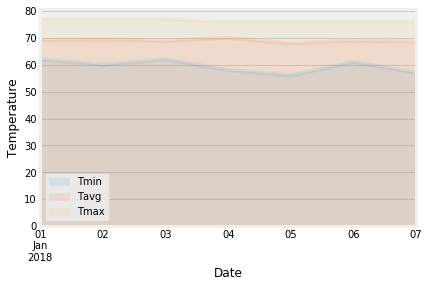

In [143]:
#testing
weather = HonoluluHI_WeatherDB()
# weather.get_table_metadata()
# weather.get_prcp_data_last_yr()
# weather.print_prcp_data_last_yr()
# weather.stations_data("Number of unique stations")
# "WAIHEE 837.5, HI US"
# weather.station_min_avg_max_temp("WAIHEE 837.5, HI US")
# weather.station_temp_data("WAIHEE 837.5, HI US", show_chart=True)
# df_June_avg_temp = weather.month_avg_temperatures(6)
# df_Dec_avg_temp = weather.month_avg_temperatures(12)
# df_avg_temp_Jun_Dec = pd.merge(df_June_avg_temp, df_Dec_avg_temp, on="year")
# df_avg_temp_Jun_Dec
# Plotting the data

# # Scatter Plot of Data
# fig, ax = plt.subplots(2, 1)
# ax[0].scatter(df_avg_temp_Jun_Dec['year'], df_avg_temp_Jun_Dec['AvgT_mth 6'], label="June")
# ax[0].scatter(df_avg_temp_Jun_Dec['year'], df_avg_temp_Jun_Dec['AvgT_mth 12'], label="Dec")
# ax[0].set_xlabel("year")
# ax[0].set_ylabel("temp.")
# ax[0].set_ylim(65,80)
# ax[0].legend(loc="lower right")

# # Histogram Plot of Data
# ax[1].hist(df_avg_temp_Jun_Dec['AvgT_mth 6'], 10, density=True, alpha=0.7, label="June")
# ax[1].hist(df_avg_temp_Jun_Dec['AvgT_mth 12'], 10, density=True, alpha=0.7, label="Dec")
# ax[1].axvline(df_avg_temp_Jun_Dec['AvgT_mth 6'].mean(), color='k', linestyle='dashed', linewidth=1)
# ax[1].axvline(df_avg_temp_Jun_Dec['AvgT_mth 12'].mean(), color='k', linestyle='dashed', linewidth=1)
# ax[1].set_xlabel("temp.")
# ax[1].set_ylabel("freq.")
# ax[1].legend()  

# # two sided T-test without assumption of equal variances  
# stats.ttest_ind(df_avg_temp["AvgT_Jun"], df_avg_temp["AvgT_Dec"], equal_var=False)

weather.calc_temps('2012-02-28','2012-03-05')
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_vacation_date = '2018-01-01'
end_vacation_date = '2018-01-07'

period_before_months = 12
period_start = month_offset(-period_before_months, start_vacation_date)
period_end = month_offset(-period_before_months, end_vacation_date)

temp_of_interest = weather.calc_temps(period_start, period_end)
temp_of_interest

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# x = 0
# y = temp_of_interest[0][1]
# upper_error = temp_of_interest[0][2] - temp_of_interest[0][1]
# lower_error = temp_of_interest[0][1] - temp_of_interest[0][0]

# fig, ax = plt.subplots(1, 1, figsize=(3,6))
# ax.bar(x, y, color="#F7B79F")
# ax.set_title("Trip Avg Temp")
# ax.set_xticks([])
# ax.set_ylabel("Temp (F)")
# ax.set_xlim(-1,1)
# ax.errorbar(x, y, yerr=[[lower_error],[upper_error]], color="black") 

# weather.get_rainfall_data(period_start, period_end)
#weather.daily_normals("01-01")

# Use the start and end date to create a range of dates
lst_vacation_dmy = pd.date_range(start=start_vacation_date, end=end_vacation_date)

# Stip off the year and save a list of %m-%d strings
lst_vacation_days = [dt.datetime.strftime(x, '%m-%d') for x in lst_vacation_dmy]

# Loop through the list of %m-%d strings and calculate the normals for each date
lst_daily_normals = [[weather.daily_normals(x)[0][0], \
                      weather.daily_normals(x)[0][1], \
                      weather.daily_normals(x)[0][2]] \
                     for x in lst_vacation_days]

lst_daily_normals = np.transpose(lst_daily_normals)
lst_daily_normals
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_est_temp_for_vacation = \
    pd.DataFrame(zip(lst_vacation_dmy,*lst_daily_normals))
df_est_temp_for_vacation = \
    df_est_temp_for_vacation.rename(columns={
        0: "Day",
        1: "Tmin",
        2: "Tavg",
        3: "Tmax"})
df_est_temp_for_vacation = df_est_temp_for_vacation.set_index("Day")
df_est_temp_for_vacation

# Plot the daily normals as an area plot with `stacked=False`
fig = plt.figure(figsize=(16,16))
ax = df_est_temp_for_vacation.plot(kind="area", stacked=False, alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")

# Temperature Analysis II